Implement the mini-batch gradient descent scheme and repeat the experiment described in Example 3.27. Create a set of two the cost function history plots like those shown in Figure 3.27 to come to a similar conclusion to that given in the Example.

$$g(w) = \sum_{p=1}^{P} g_p(w) = \sum_{p=1}^{P}(a_p + b_pw + c_pw^2)$$

In [129]:
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True   
import matplotlib.pyplot as plt
# import statment for gradient calculator
from autograd import grad
from autograd import numpy as np
from autograd import value_and_grad
# import pickle data loading functionality
from sklearn.externals import joblib

def gradient_descent(g,alpha_choice,max_its,w):
    gradient = value_and_grad(g)
    weight_history = []
    cost_history = []
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)
            
        grad_eval = grad_eval

        # take step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w) 
    cost_history.append(g(w))  
    return weight_history,cost_history

from autograd.misc.flatten import flatten_func

#numtrain is P
def batch_gradient_descent(g,alpha_choice,max_epochs,w, num_train, batch_size):
    g_flat, unflatten, w = flatten_func(g, w)
    gradient = value_and_grad(g_flat)
    
    weight_history = [unflatten(w)]
    cost_history = [g_flat(w,np.arange(num_train))]

    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_train, batch_size)))

    alpha = 0
    for k in range(max_epochs):
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        train_cost = 0
        for b in range(num_batches):
            #get indices for current mini batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_train))
            
            cost_eval,grad_eval = gradient(w, batch_inds)
            grad_eval.shape = np.shape(w)
            
            #take step
            w = w-alpha*grad_eval
            
            train_cost = g_flat(w,np.arange(num_train))
            weight_history.append(unflatten(w))
            cost_history.append(train_cost) 
    return weight_history,cost_history


# load in weights of random convex quadratics
coeffs = joblib.load('coeffs/random_quadratic_weights.pkl') 

# iter-based function for sum of quadratics
def g(w,iter):
    P = len(coeffs)
    cost = 0
    for i in iter:
        # get quadratic
        coeff = coeffs[i]
        a = coeff[0]
        b = coeff[1]
        c = coeff[2]

        # add to term
        cost += (a + b*w + c*w**2)
    return cost/P

In [130]:
P=100
init_point = 0.5

full_batch_size = P
batch_size_1 = 1
batch_size_2 = 10
alpha = 1
num_epochs = 2
num_train = P
wh1, ch1_full = batch_gradient_descent(g, alpha, num_epochs, init_point, num_train, full_batch_size)
wh2, ch2_stoch = batch_gradient_descent(g, alpha, num_epochs, init_point, num_train, batch_size_1)
wh3, ch3_mini = batch_gradient_descent(g, alpha, num_epochs, init_point, num_train, batch_size_2)


In [131]:
def compare_runs(full_cost_hist,stoch_cost_hist,minibatch_cost_hist):
    # create figure and color pattern
    fig = plt.figure(figsize = (10,3))
    colors = ['k','r','b']

    ### plot all with respect to smallest mini-batch size ###
    ax = plt.subplot(1,2,1)

    # num steps per run
    stoch_count = len(stoch_cost_hist)
    mini_count = len(minibatch_cost_hist)
    full_count = len(full_cost_hist)

    # plot stochastic
#     ax.plot(stoch_cost_hist, label='batch size = 1',c = colors[0],linewidth=1.5)
    ax.plot(stoch_cost_hist, 'k-', label='batch size = 1',linewidth=1.5)

    # plot mini and full batch with respect to stochastic
    range_mini = np.linspace(0,stoch_count,mini_count)
    ax.plot(range_mini,minibatch_cost_hist, label='batch size = 10',c = colors[1],linewidth=1)
    ax.scatter(range_mini,minibatch_cost_hist,c=colors[1],s=90,edgecolor = 'w',linewidth=0.5)

    range_full = np.linspace(0,stoch_count,full_count)
    ax.plot(range_full,full_cost_hist, label='full batch',c = colors[2],linewidth=1)
    ax.scatter(range_full,full_cost_hist,c=colors[2],s=90,edgecolor = 'w',linewidth=0.5)

    # label panel
    ax.set_title('progress with respect to batch size = 1 method')
    ax.set_xlabel('single summand')
    ax.legend(loc="upper right")

    ### plot with respect to epoch number ###
    ax = plt.subplot(1,2,2)

    # plot stochastic batch
    inds_stoch = np.linspace(0,stoch_count,full_count)
    inds_stoch = [int(v) for v in inds_stoch]
    inds_stoch[-1]-=1
    plot_stoch = [stoch_cost_hist[v] for v in inds_stoch]
    ax.plot(plot_stoch, label='batch size = 1',c = colors[0],linewidth=1.5)
    ax.scatter(np.arange(full_count),plot_stoch,c=colors[0],s=90,edgecolor = 'w',linewidth=0.5)
    
    # plot mini and full batch with respect to stochastic
    inds_mini = np.linspace(0,mini_count,full_count)
    inds_mini = [int(v) for v in inds_mini]
    inds_mini[-1]-=1
    plot_mini = [minibatch_cost_hist[v] for v in inds_mini]
    ax.plot(plot_mini, label='batch size = 10',c = colors[1],linewidth=1)
    ax.scatter(np.arange(full_count),plot_mini,c=colors[1],s=90,edgecolor = 'w',linewidth=0.5)

    # plot full cost
    ax.plot(full_cost_hist, label='full batch',c = colors[2],linewidth=1)
    ax.scatter(np.arange(full_count),full_cost_hist,c=colors[2],s=90,edgecolor = 'w',linewidth=0.5)
    ax.set_title('progress with respect to full batch method')
    ax.set_xticks(np.arange(full_count))
    ax.set_xlabel('full epochs')
    ax.legend(loc="upper right")

    # plot all with respect to epoch number
    plt.show()
    


<IPython.core.display.Javascript object>


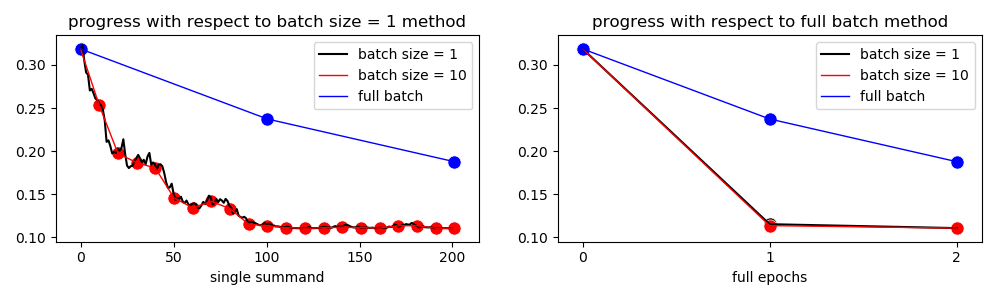

In [132]:
compare_runs(ch1_full,ch2_stoch,ch3_mini)